# Load libraries and data

In [200]:
!pip install --upgrade tensorflow-probability lida llmx 1>/dev/null
!pip install whit-phys-util 1>/dev/null

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import whit_phys_util as buc
from string import ascii_uppercase
import scipy.constants as sciConst

# Connect to GitHub

In [202]:
repo = buc.local_repository("https://github.com/PS251-FA23/led-plancks-constant-th-j")

Repository exists at this location. Pulling changes from GitHub.


In [203]:
leds = list(ascii_uppercase[0:12])
print(leds)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


In [204]:
dfc = {} #collection of DataFrames for LED I-V data

In [205]:
for led in leds:
  dfc[led] = pd.read_csv(f'LED_{led}.csv')

In [206]:
dfc['A'].head()

,Voltage (V),Current (A)
0,0.00,-0.0
1,0.01,-0.0
2,0.02,-0.0
3,0.03,-0.0
4,0.04,-0.0


In [207]:
wavelengths = pd.read_table('LED wavelengths.tsv', index_col = 0)
wavelengths

,Peak wavelength (nm)
LED,
A,363.7
B,375.4
C,391.0
D,462.2
E,523.4
F,573.8
G,590.1
H,630.2
I,649.7


In [208]:
dfw = wavelengths['Peak wavelength (nm)']
dfw

LED
A    363.7
B    375.4
C    391.0
D    462.2
E    523.4
F    573.8
G    590.1
H    630.2
I    649.7
J    774.5
K    868.5
L    940.0
Name: Peak wavelength (nm), dtype: float64

# Graphing current vs. total voltage

In [209]:
V_total = {}
I = {}
for led in leds:
  V_total[led] = dfc[led]['Voltage (V)']
  I[led] = dfc[led]['Current (A)']

In [210]:
led_sets = [leds[0:4], leds[4:8], leds[8:12]]
numSets = len(led_sets)

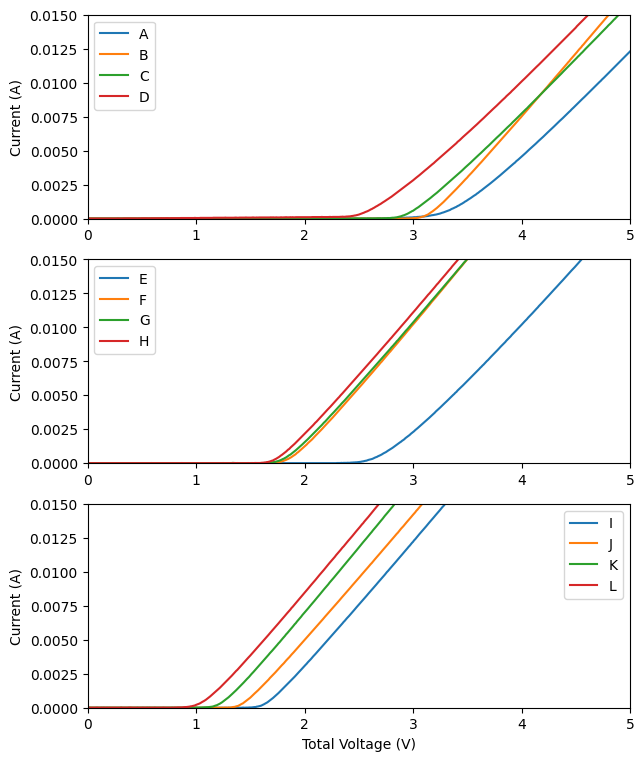

In [211]:
fig1, ax1 = plt.subplots(numSets, 1, figsize = (7, 9))
for i in range(numSets):
  for led in led_sets[i]:
    ax1[i].plot(V_total[led], I[led], label = led)
  ax1[i].set_ylabel("Current (A)")
  ax1[i].set_xlim(0, 5)
  ax1[i].set_ylim(0, 0.015)
  ax1[i].legend()
ax1[numSets-1].set_xlabel("Total Voltage (V)");

# Graphing current vs. LED voltage

In [212]:
V_LED = {}
for led in leds:
  V_LED[led] = V_total[led]-98.98*I[led]

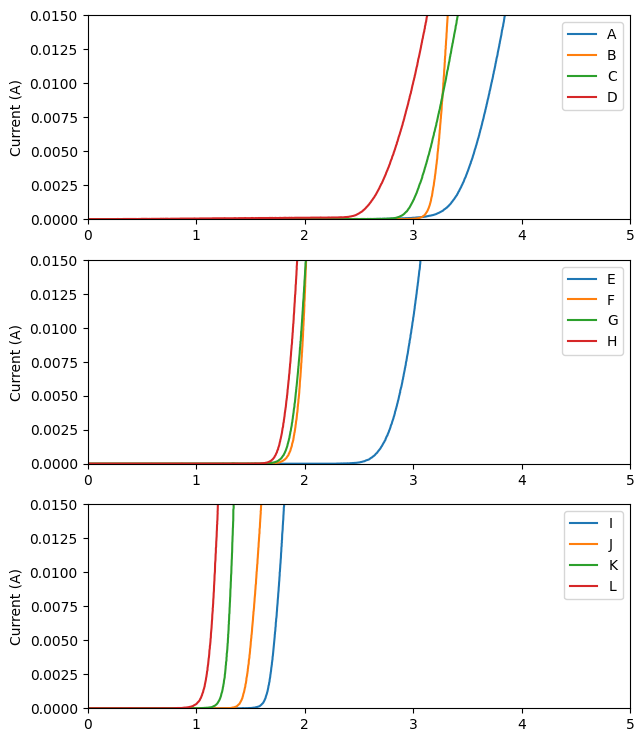

In [213]:
fig2, ax2 = plt.subplots(numSets, 1, figsize = (7, 9))
for i in range(numSets):
  for led in led_sets[i]:
    ax2[i].plot(V_LED[led], I[led], label = led)
  ax2[i].set_ylabel("Current (A)")
  ax2[i].set_xlim(0, 5)
  ax2[i].set_ylim(0, 0.015)
  ax2[i].legend()
ax1[numSets-1].set_xlabel("LED Voltage (V)");

# Prototyping locating activation

In [214]:
base_indices = np.where(V_LED['D']<=0.6)[0]

In [215]:
avgBase = I['D'][base_indices].mean()
stdBase = I['D'][base_indices].std()
print(avgBase, stdBase)

6.065573770491805e-06 7.366294528592188e-06


In [216]:
thresh = avgBase + 18*stdBase
print(thresh)

0.00013865887528515122


In [217]:
above_thresh_indices = np.where(I['D'] > thresh)
first_above_thresh = above_thresh_indices[0][0]
print(first_above_thresh)

235


In [218]:
V_LED['D'][first_above_thresh]

2.336142799999994

# Locating activation voltage for all LEDs

In [219]:
V_on_list = []

In [220]:
for led in leds:
  above_thresh_indices = np.where(I[led] > thresh)
  first_above_thresh = above_thresh_indices[0][0]
  V_on_list.append(V_LED[led][first_above_thresh])

In [221]:
V_on = np.array(V_on_list)
print (V_on)

[3.0661428 3.0761428 2.865153  2.3361428 2.535153  1.785153  1.7361428
 1.675153  1.585153  1.3761428 1.1641632 0.965153 ]


# Determining h

In [222]:
dfw

LED
A    363.7
B    375.4
C    391.0
D    462.2
E    523.4
F    573.8
G    590.1
H    630.2
I    649.7
J    774.5
K    868.5
L    940.0
Name: Peak wavelength (nm), dtype: float64

In [223]:
V_on

array([3.0661428, 3.0761428, 2.865153 , 2.3361428, 2.535153 , 1.785153 ,
       1.7361428, 1.675153 , 1.585153 , 1.3761428, 1.1641632, 0.965153 ])

In [230]:
## Gets rid of bad data point. LED E
dfw_good = dfw.drop('E')
V_on_good = np.array(V_on_list[0:4] + V_on_list[5:])

In [231]:
fit, fitFunc = buc.prettyPolyFit(1/dfw_good,V_on_good)
fit

,slope,intercept
value,1239.579101,-0.310371
uncertainty,58.650656,0.112953


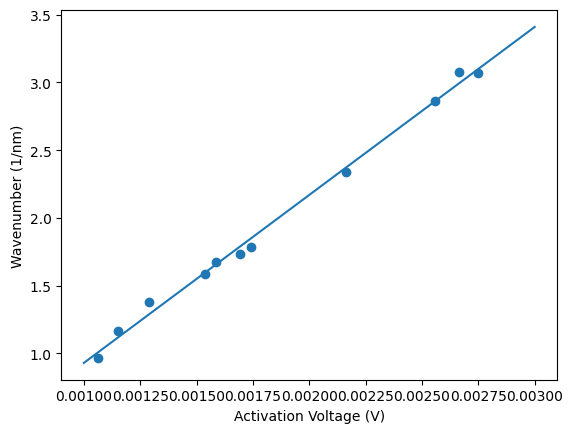

In [232]:
fig3, ax3 = plt.subplots()
ax3.scatter(1/dfw_good, V_on_good)
ax3.set_xlabel('Activation Voltage (V)')
ax3.set_ylabel('Wavenumber (1/nm)')
w_fit = np.linspace(0.001,.003,2)
ax3.plot(w_fit, fitFunc(w_fit));

In [233]:
e = sciConst.e
c = sciConst.c
h = fit['slope']['value']*(e/c)*1e-9
dh = fit['slope']['uncertainty']*(e/c)*1e-9
print (h, dh)

6.624665227060493e-34 3.134458774112983e-35


In [234]:
percentErr = (h - sciConst.h)/sciConst.h*100
percentErr

-0.021202959034572002

In [ ]:
### Etherm is the y intercept. V_0 = hc/ex + Etherm/e

In [ ]:
Etherm = (e*V_on[0])-((h*c)/dfw[0])
Etherm

In [ ]:
Etherm = (e*V_on[1])-((h*c)/dfw[1])
Etherm

In [ ]:
Etherm = (e*V_on[2])-((h*c)/dfw[2])
Etherm

In [ ]:
Etherm = (e*V_on[3])-((h*c)/dfw[3])
Etherm


In [ ]:
Etherm = (e*V_on[4])-((h*c)/dfw[4])
Etherm

In [ ]:
Etherm = (e*V_on[5])-((h*c)/dfw[5])
Etherm

In [ ]:
Etherm = (e*V_on[6])-((h*c)/dfw[6])
Etherm

In [ ]:
Etherm = (e*V_on[7])-((h*c)/dfw[7])
Etherm

In [ ]:
Etherm = (e*V_on[8])-((h*c)/dfw[8])
Etherm

In [ ]:
Etherm = (e*V_on[9])-((h*c)/dfw[9])
Etherm

In [ ]:
Etherm = (e*V_on[10])-((h*c)/dfw[10])
Etherm

In [ ]:
Etherm = (e*V_on[11])-((h*c)/dfw[11])
Etherm

# Reflection

1) Not all the values of $E_{thermal}$ are the same; the data is not consistent.

2) The $E_{thermal}$ values can be put into 3 groups: ~$4-5 \times 10^{-19} eV$, ~$2.5-3 \times 10^{-19} eV$, and ~$1.5-2.2 \times 10^{-19} eV$. These groups are not the same as before when graphing the LEDs and the corresponding voltages and currents, however, are similar in $E_{thermal}$ values.